In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 335137245857127707
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2235991955859217124
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [1]:
!pip install segmentation_models
!pip install matplotlib==3.5.1
!pip install "opencv-python-headless<4.3"
!pip install albumentations==1.1.0

  Using cached opencv_python_headless-3.4.17.63-cp36-abi3-win_amd64.whl (31.2 MB)
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, but you have opencv-python-headless 3.4.17.63 which is incompatible.
albumentations 1.1.0 requires opencv-python-headless>=4.1.1, but you have opencv-python-headless 3.4.17.63 which is incompatible.


  Using cached opencv_python_headless-4.5.5.64-cp36-abi3-win_amd64.whl (35.3 MB)


  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 3.4.17.63
    Uninstalling opencv-python-headless-3.4.17.63:
      Successfully uninstalled opencv-python-headless-3.4.17.63


In [2]:
%env SM_FRAMEWORK=tf.keras

import albumentations as A
import cv2
import gc
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
#from segmentation_models.metrics import iou_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError as mse_loss
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import tifffile as tiff
import time

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [2]:
AUGMENTATIONS_TRAIN =A.Compose([
                                A.OneOf([
                                         A.ShiftScaleRotate (p=.8),
                                         A.ElasticTransform (p=.8),
                                         A.OpticalDistortion(p=.8),
                                         A.GridDistortion   (p=.8)
                                         ]),
                                #A.RandomGamma(p=.2),
                                #A.InvertImg(p=.5),
                                A.RandomGridShuffle(p=.3),
                                A.HorizontalFlip(p=.5),
                                #A.CLAHE(p=.2),
                                #A.Downscale(p=.1),
                                #A.Blur(p=.3), #?
                                A.Cutout(p=.2),
                                #A.GaussNoise(p=.3) #?
                                ])

AUGMENTATIONS_TEST = A.Compose([
                                # A.ToFloat(max_value=255)
                                A.NoOp()
                                ])

C:\Users\bon\Anaconda3\envs\komtuveu\lib\site-packages\albumentations\augmentations\transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [3]:
def mse(y_true, y_pred):
  mse = mse_loss()
  return mse(y_true, y_pred)

In [4]:
def untile(im):
    nim=[]
    for i in range(5):
        for j in range(5):
            nim.append(im[:,:,(j)*1024:(j+1)*1024,(i)*1024:(i+1)*1024])
    return nim

def selmax(im):
    nim=np.zeros((25,4,1024,1024))
    num=0
    for i in im:
        nim[num]=i[0]
        for j in i:
            if np.mean(j[0])>np.mean(nim[num][0]):
                nim[num]=j
        num+=1
    return np.transpose(nim,(0,2,3,1))

dataim=[tiff.imread("../Documents/Microscopie/2022-04-21_BioSamples_Acquisition/01_NDD+interne_5-5_1024-1024_5s.lsm"),
        tiff.imread("../Documents/Microscopie/2022-04-21_BioSamples_Acquisition/05_NDD+interne_5-5_1024-1024_5s.lsm"),
        tiff.imread("../Documents/Microscopie/2022-04-21_BioSamples_Acquisition/07_NDD+interne_5-5_1024-1024_5s.lsm")]
imgs=None
for im in dataim:
    im2=untile(im)
    im3=selmax(im2)
    if imgs is None:
        imgs=im3
    else:imgs=np.concatenate((imgs,im3),axis=0)
    del im2,im3
del dataim
gc.collect()

437

In [33]:
print(np.expand_dims(im[0],axis=0).shape)

(1, 4, 5120, 5120)


In [11]:
imshape=np.shape(np.expand_dims(imgs[0,:,:,0],axis=-1))
nddr=np.expand_dims(imgs[...,0],axis=3)
nddg=np.expand_dims(imgs[...,1],axis=3)
intg=np.expand_dims(imgs[...,2],axis=3)
intr=np.expand_dims(imgs[...,3],axis=3)
X=np.concatenate((intg,intr),axis=0)
Y=np.concatenate((nddg,nddr),axis=0)
X=np.concatenate((X,X,X),axis=3)
Y=np.concatenate((Y,Y,Y),axis=3)
np.random.seed(seed=42)
index=np.random.permutation(len(X))
X=X[index]
Y=Y[index]
sep=int((3/4)*len(X))
x_train,x_valid,y_train,y_valid=X[:sep],X[sep:],Y[:sep],Y[sep:]
del X,Y
del imgs,nddr,nddg,intg,intr
gc.collect()

0

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class Tile:
    '''
    Usage    : Tile(image,tilesize,overlap,verbose)
    image    : Array of shape [height,width,canals]
    tilesize : The output will be of shape [tilesize,tilesize,canals]
    overlap  : Amount of pixel common between two consecutive tiles
    ================================================================
    Methods  :
    padding(mode="reflect"): Returns a padded image via numpy.pad usage
    tilegeneration()       : Returns a list parts of original image(tiles)
    tilevis(concat=True)   : Plots the tiles list for the image
    detmask()              : Returns the mask of overlapping areas
    reconstruct()          : Builds the image back out of the tile list   
    '''
    
    def __init__(self, image, tilesize=None,overlap=None,verbose=False):
        
        self.im = image
        self.s  = np.shape(self.im)[:2]
        if tilesize is None:tilesize=self.s[0]//4
        self.t  = tilesize
        if overlap is None :overlap =tilesize//4
        self.o  = overlap
        self.verbose=verbose
        self.verdata()
        self.to = self.t-self.o
        self.nbt= [(self.s[0]-self.o)//self.to+1,(self.s[1]-self.o)//self.to+1]
        self.p  = None
        self.pIm= None
        self.tl = None
        
    def verdata(self):
        if (np.shape(self.im)[0]%2)!=0:
            if self.verbose:print("Changing image to an even dimension value, one pixel was removed on axis zero.")
            self.im=self.im[:-1]
        if (np.shape(self.im)[1]%2)!=0:
            if self.verbose:print("Changing image to an even dimension value, one pixel was removed on axis one.")
            self.im=self.im[:,:-1]
        if self.o%2!=0:
            if self.verbose:print("Please use even value for overlap, overlap was reduced by one.")
            self.o-=1
        if self.t>np.shape(self.im)[0] or self.t>np.shape(self.im)[1]:
            if self.verbose:print("You probably didn't do what you want, you will just have one padded image. (Tile size larger than image)")
                      
    def detpad(self):
        psize=[(self.nbt[0]*self.to+self.o)-self.s[0],(self.nbt[1]*self.to+self.o)-self.s[1]]
        for i in range(len(psize)):
            if  psize[i]==self.to:
                psize[i]%=self.to
                self.nbt[i]-=1
        return psize
    
    def padding(self,mode="reflect"):
        if self.p is None:
            self.p=self.detpad()
        padval=int(self.p[0]/2),int(self.p[1]/2)
        pIm=np.pad(self.im,((padval[0],padval[0]),(padval[1],padval[1]),(0,0)),mode=mode)
        del padval
        gc.collect()
        return pIm
    
    def tilegeneration(self):
        if self.pIm is None:
            self.pIm=self.padding()
        tiles=[]
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                tiles.append(self.pIm[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t])
        return tiles
    
    def tilevis(self,concat=True):
        if self.tl is None:
            self.tl=self.tilegeneration()
        plt.figure(figsize =( 3*self.nbt[1], 3*self.nbt[0]))
        if not concat:
            for i in range(self.nbt[0]):
                for j in range(self.nbt[1]):
                    ax = plt.subplot(self.nbt[0], self.nbt[1], i*self.nbt[1]+j+1)
                    ax.axis("off")
                    plt.imshow(self.tl[i*self.nbt[1]+j])
        else:
            im=[]
            for i in range(self.nbt[0]):
                line=[]
                for j in range(self.nbt[1]):
                    if j==0: line=self.tl[i*self.nbt[1]+j]
                    else: line = np.concatenate((line,self.tl[i*self.nbt[1]+j]),axis=1)
                if i==0:im=line
                else:im=np.concatenate((im,line),axis=0)
            plt.imshow(im[...,0])
        del im
        gc.collect()
        plt.show()
        
    
    def detmask(self):
        if self.pIm is None:
            self.pIm=self.padding()
        mask=np.zeros(np.shape(self.pIm)[:2])
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                mask[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t]+=np.ones((self.t,self.t))
        return mask[int(self.p[0]/2):self.s[0]+int(self.p[0]/2),int(self.p[1]/2):self.s[1]+int(self.p[1]/2)]
    
    def reconstruct(self,tl=None):
        if tl is None:
            tl=self.tilegeneration()
        reim=np.zeros(np.shape(self.pIm))
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                reim[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t]+=tl[i*self.nbt[1]+j]
        reim=reim[int(self.p[0]/2):self.s[0]+int(self.p[0]/2),int(self.p[1]/2):self.s[1]+int(self.p[1]/2)]
        mask=self.detmask()
        for i in range(np.shape(reim)[2]):
            reim[...,i]/=mask
        if np.max(reim)<=1:
            reim=(reim*255)
        return reim.astype(int)


In [13]:
preproc=sm.get_preprocessing("efficientnetb3")
def tiling(dataset,tilesize=256,overlap=64):
    
    tiled=[]
    for i in dataset:
        tempi=Tile(i,tilesize,overlap)
        tiled.append(tempi.tilegeneration())
    del tempi
    gc.collect()
    return np.reshape(tiled,(-1,tilesize,tilesize,np.shape(dataset)[-1]))
tilesize=256
overlap=64
x_show,y_show=np.copy(x_valid),np.copy(y_valid)
x_train,y_train=tiling(x_train[:10]),tiling(y_train[:10])
x_valid,y_valid=tiling(x_valid),tiling(y_valid)

In [14]:
class Imgen(Sequence):

    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = np.copy(self.x[idx * self.batch_size:(idx + 1) * self.batch_size])
        batch_y = np.copy(self.y[idx * self.batch_size:(idx + 1) * self.batch_size])
        img=[]
        msk=[]
        for i in range(batch_x.shape[0]):
            agm = self.augment(image=batch_x[i], mask=batch_y[i])
            img.append(agm["image"])
            msk.append(agm["mask"])
        del batch_x,batch_y
        gc.collect()
        img=np.array(img)
        msk=np.array(msk)
        img=preproc(img)
        return img.astype("float32"),msk.astype("float32")

In [15]:
from classification_models.tfkeras import Classifiers
VGG16, preprocess_input = Classifiers.get('vgg16')
lossmodel = VGG16(input_shape=(256, 256, 3), weights='imagenet',include_top=False)
lossmodel.trainable = False
for l in lossmodel.layers:
    l.trainable = False

In [16]:
y_loss = lossmodel.predict(y_train.astype("float32"))

In [13]:
print(np.shape(y_loss))

(250, 8, 8, 512)


In [14]:
#full_y_train = lossmodel.predict(y_train[:10])
#train_gen = Imgen(x_train.astype("uint8")[:10], full_y_train, batch_size=24, augmentations=AUGMENTATIONS_TEST)#=AUGMENTATION_TRAIN)
#valid_gen = Imgen(x_valid.astype("uint8"), y_valid, batch_size=24, augmentations=AUGMENTATIONS_TEST)

In [10]:
sm.set_framework('tf.keras')
sm.framework()
mainmodel = Unet("efficientnetb3",encoder_weights="imagenet",activation="linear", input_shape=(256, 256, 3),classes=3)

In [18]:
import keras
inp = keras.layers.Input((256,256,3))
out1 = mainmodel(inp)
out2 = lossmodel (out1)
fullModel=Model(inputs=inp,outputs=[out1,out2])

In [19]:
fullModel.layers[1]._name="mainmodel"
fullModel.layers[2]._name="fullmodel"

In [20]:
fullModel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mainmodel (Functional)      (None, 256, 256, 3)       17868123  
                                                                 
 fullmodel (Functional)      (None, 8, 8, 512)         14714688  
                                                                 
Total params: 32,582,811
Trainable params: 17,778,843
Non-trainable params: 14,803,968
_________________________________________________________________


In [21]:
# lossOut = lossmodel(mainmodel.output) #you pass the output of one model to the other
# fullModel = Model(inputs=mainmodel.input,outputs=lossOut)


In [22]:
fullModel.layers[-1]._name="fullmodel"
mainmodel.layers[-1]._name="mainmodel"

In [23]:
# fullModel.summary()

In [24]:
# Fit the model on the batches generated by datagen.flow().
fullModel.compile(Adam(learning_rate=1e-4),
                  loss={"mainmodel":mse,
                        "fullmodel":mse
                       },loss_weights=[1,100])

In [10]:
mainmodel.load_weights("perclossb3_1.h5")

In [26]:
es_callback=tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

x_train_processed=preproc(np.copy(x_train.astype("float32")))
y_train_processed=np.copy(y_train.astype("float32"))

In [95]:
history1 = fullModel.fit(
    x=x_train_processed,y={"mainmodel":y_train_processed,"fullmodel":y_loss},
    epochs=100,
    batch_size=16,
    callbacks=[es_callback]
)

Epoch 1/100
16/16 [==============================] - 42s 1s/step - loss: 313.8357 - mainmodel_loss: 80.9424 - fullmodel_loss: 2.3289
Epoch 2/100
16/16 [==============================] - 21s 1s/step - loss: 300.1075 - mainmodel_loss: 79.3604 - fullmodel_loss: 2.2075
Epoch 3/100
16/16 [==============================] - 21s 1s/step - loss: 300.5477 - mainmodel_loss: 81.1112 - fullmodel_loss: 2.1944
Epoch 4/100
16/16 [==============================] - 21s 1s/step - loss: 313.3297 - mainmodel_loss: 84.3651 - fullmodel_loss: 2.2896
Epoch 5/100
16/16 [==============================] - 21s 1s/step - loss: 314.2053 - mainmodel_loss: 84.5675 - fullmodel_loss: 2.2964
Epoch 6/100
16/16 [==============================] - 21s 1s/step - loss: 305.2470 - mainmodel_loss: 84.3408 - fullmodel_loss: 2.2091
Epoch 7/100
16/16 [==============================] - 21s 1s/step - loss: 299.5901 - mainmodel_loss: 83.1379 - fullmodel_loss: 2.1645
Epoch 8/100
16/16 [==============================] - 21s 1s/step - lo

In [ ]:
mainmodel.save_weights("content/gdrive/MyDrive/Biphoton/perclossb3_1.h5")

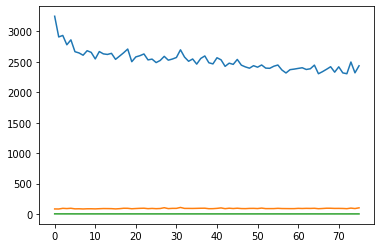

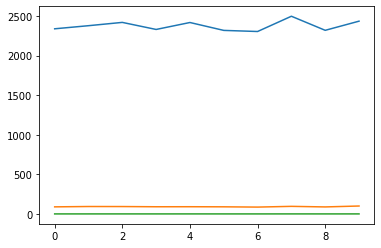

In [80]:
for h in [history1]:
    losscurve=h.history["loss"]
    vlosscurve=h.history["mainmodel_loss"]
    flosscurve=h.history["fullmodel_loss"]
    plt.figure()
    plt.plot(losscurve)
    plt.plot(vlosscurve)
    plt.plot(flosscurve)
    plt.show()
    plt.figure()
    plt.plot(losscurve[-10:])
    plt.plot(vlosscurve[-10:])
    plt.plot(flosscurve[-10:])
    plt.show()

In [ ]:
print(np.max(x_train[:10].astype("uint8")))
mainmodel.evaluate(preproc(x_train[:10].astype("uint8")),y_train[:10])

In [5]:
imshape=np.shape(np.expand_dims(imgs[0,:,:,0],axis=-1))
nddr=np.expand_dims(imgs[...,0],axis=3)
nddg=np.expand_dims(imgs[...,1],axis=3)
intg=np.expand_dims(imgs[...,2],axis=3)
intr=np.expand_dims(imgs[...,3],axis=3)
X=np.concatenate((intg,intr),axis=0)
Y=np.concatenate((nddg,nddr),axis=0)
X=np.concatenate((X,X,X),axis=3)
Y=np.concatenate((Y,Y,Y),axis=3)
x_test=X
y_test=Y
del X,Y
del imgs,nddr,nddg,intg,intr
gc.collect()

0

In [9]:
preproc=sm.get_preprocessing("efficientnetb3")
def tiling(dataset,tilesize=256,overlap=64):
    
    tiled=[]
    for i in dataset:
        tempi=Tile(i,tilesize,overlap)
        tiled.append(tempi.tilegeneration())
    del tempi
    gc.collect()
    return np.reshape(tiled,(-1,tilesize,tilesize,np.shape(dataset)[-1]))
tilesize=256
overlap=64
x_show,y_show=np.copy(x_test),np.copy(y_test)
x_test,y_test=tiling(x_test),tiling(y_test)

In [11]:
mainmodel.load_weights("goodperclossb3_2.h5")

In [37]:
from tensorflow.keras.models import load_model
model=load_model("streetcareoverfitb3_2",custom_objects={
  "mean_squared_error_loss": mse})

In [38]:
print(np.shape(x_test))

(6250, 256, 256, 3)


In [ ]:
res=model.predict(preproc(np.copy(x_test.astype("float32"))))

In [61]:
del res, mres, model, xtrec, fres
gc.collect()

566137

In [12]:
mres=mainmodel.predict(preproc(np.copy(x_test.astype("float32"))))

In [13]:
tinfo=Tile(np.zeros((1024,1024,3)),tilesize,overlap)
xtrec=[]
tinfo.pIm=tinfo.padding()
nim=tinfo.nbt[0]*tinfo.nbt[1]
print(np.shape(mres))
for i in range(len(mres)//nim):
    xtrec.append(tinfo.reconstruct(mres[nim*i:nim*(i+1)]))
print(np.shape(xtrec))
print(np.max(xtrec))

(6250, 256, 256, 3)
(250, 1024, 1024, 3)
328


In [14]:
fres=np.zeros([10,5120,5120,3])
for k in range(10):
    for j in range (5):
        for i in range (5):
            fres[k,i*1024:i*1024+1024,j*1024:j*1024+1024]=(xtrec[25*k+5*j+i])

In [ ]:
plt.figure(figsize=(30,30))
diff=(((255*(fres[0]-np.min(fres[0]))/np.max(fres[0])-np.min(fres[0])).astype("uint8"))-fres[0].astype("uint8"))
plt.imshow(diff,cmap="gray")
plt.figure(figsize=(30,30))
plt.imshow((255*(fres[0]-np.min(fres[0]))/np.max(fres[0])-np.min(fres[0])).astype("uint8"),cmap="gray")
plt.figure(figsize=(30,30))
plt.imshow(fres[0].astype("uint8"),cmap="gray")


In [21]:
for i in range(len(fres)):
    tiff.imwrite("testgoodimpred%d"%i,(255*(fres[i]-np.min(fres[i]))/(np.max(fres[i])-np.min(fres[i]))).astype("uint8"),resolution=(1/10,1/10))

In [19]:
if True:
    from PIL import Image
    for i in range(len(fres)):
        im=Image.fromarray((255*(fres[i]-np.min(fres[i]))/(np.max(fres[i])-np.min(fres[i]))).astype("uint8"))
        im.save("fullgoodpred%d.png"%i)
        del im
gc.collect()

0

In [ ]:
a = np.mean(y_test[1500],axis=2)
# a[a>-10]=0
plt.figure(figsize=(30,30))
print(np.min(a),np.max(a),np.mean(a))
plt.imshow((a-np.min(a))/(np.max(a)-np.min(a)),cmap="gray")
print(np.min(a-np.min(a))/(np.max(a)-np.min(a)))
print(np.max(a-np.min(a))/(np.max(a)-np.min(a)))

In [ ]:
n=6
pick=x_tbio[10+n]
plt.imshow(pick.astype("uint8"))
plt.figure()
img=np.mean(res[n],axis=2)
nimg=(img-np.min(img))/(np.max(img)-np.min(img))
plt.imshow(nimg,cmap="gray")
plt.figure()
plt.imshow(y_tbio[10+n].astype("uint8"),cmap="gray")
print(np.min(res[n]),np.max(res[n]),np.mean(res[n]))
print(np.min(nimg),np.max(nimg),np.mean(nimg))

In [ ]:
y_tile=tiling(y_test)

In [ ]:
for i,j,k in zip(x_valid[20:30],res[20:30],y_valid[20:30]):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(30,30))
    ax1.imshow((255*(i-np.min(i))/(np.max(i)-np.min(i))).astype("uint8"),cmap="gray")
    ax2.imshow((255*(j-np.min(j))/(np.max(j)-np.min(j))).astype("uint8"),cmap="gray")
    ax3.imshow((255*(k-np.min(k))/(np.max(k)-np.min(k))).astype("uint8"),cmap="gray")
plt.show()

In [ ]:
for i,j,k in zip(xtrec,x_show.astype("uint8"),y_show.astype("uint8")):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(30,30))
    ax1.imshow(((j-np.min(j))/(np.max(j)-np.min(j))),cmap="gray")
    ax2.imshow(((i-np.min(i))/(np.max(i)-np.min(i))),cmap="gray")
    ax3.imshow(((k-np.min(k))/(np.max(k)-np.min(k))),cmap="gray")
    print("mean : ",np.mean(j),np.mean(i),np.mean(k))
    print("std : ",np.std(j),np.std(i),np.std(k))
    print("snr : ",np.mean(j)/np.std(j),np.mean(i)/np.std(i),np.mean(k)/np.std(k))
    print("cv : ",np.std(j)/np.mean(j),np.std(i)/np.mean(i),np.std(k)/np.mean(k))
    plt.show()

In [ ]:
repred=np.copy(x_test[:250])
for i in range(2):
    repred=model.predict(preproc(repred.astype("uint8")))
    repred=np.concatenate((repred,repred,repred),axis=3)
    print(np.shape(repred))
repred=np.expand_dims(repred[...,0],axis=3)
tinfo=Tile(np.zeros(imshape),tilesize,overlap)
xtrec=[]
tinfo.pIm=tinfo.padding()
nim=tinfo.nbt[0]*tinfo.nbt[1]
print(np.shape(repred))
for i in range(len(repred)//nim):
    xtrec.append(tinfo.reconstruct(repred[nim*i:nim*(i+1)]))
print(np.shape(xtrec))
print(np.max(xtrec))

In [ ]:
for i in range(3):
    plt.figure(figsize=(30,30))
    plt.imshow(x_show[i].astype("uint8"),cmap="gray")
    plt.figure(figsize=(30,30))
    plt.imshow(y_show[i].astype("uint8"),cmap="gray")
    plt.figure(figsize=(30,30))
    xpred=(255*(xtrec[i]-np.min(xtrec[i]))/(np.max(xtrec[i])-np.min(xtrec[i]))).astype("uint8")
    plt.imshow(xpred,cmap="gray")

In [121]:
if True:
  from PIL import Image
  for j in range(len(xtrec)):
    np.random.seed(j)
    i=np.random.randint(0,len(res))
    xpred=(255*(res[i]-np.min(res[i]))/(np.max(res[i])-np.min(res[i]))).astype("uint8")
    x=np.array(np.concatenate((x_valid[i].astype("uint8"),xpred,y_valid[i].astype("uint8")),axis=1))
    im=Image.fromarray(x)
    im.save("gdrive/MyDrive/Biphoton/gsaves/imgtc%d.png"%j)
    del x,im,xpred
gc.collect()

131

In [31]:
if True:
    
    from PIL import Image
    for j in range(len(xtrec)):
        np.random.seed(j)
        i=np.random.randint(0,len(xtrec))
        xpred=(255*(xtrec[i]-np.min(xtrec[i]))/(np.max(xtrec[i])-np.min(xtrec[i]))).astype("uint8")
        intern=(255*(x_show[i]-np.min(x_show[i]))/(np.max(x_show[i])-np.min(x_show[i]))).astype("uint8")
        ndd=(255*(y_show[i]-np.min(y_show[i]))/(np.max(y_show[i])-np.min(y_show[i]))).astype("uint8")
        x=np.array(np.concatenate((intern,xpred,ndd),axis=1))
        im=Image.fromarray(x)
        im.save("imgc%d.png"%j)
        del x,im,xpred
gc.collect()

31

In [50]:
im=np.expand_dims(tiff.imread("testing.tif"),axis=-1)
print(np.shape(im))
testim=tiling(np.concatenate((im,im,im),axis=3))
print(np.shape(testim))
testres=mainmodel.predict(preproc(testim.astype("uint8")))
tinfo=Tile(np.zeros((768,1024,3)),tilesize,overlap)
testxtrec=[]
tinfo.pIm=tinfo.padding()
nim=tinfo.nbt[0]*tinfo.nbt[1]
print(np.shape(testres))
for i in range(len(testres)//nim):
    testxtrec.append(tinfo.reconstruct(testres[nim*i:nim*(i+1)]))
print(np.shape(testxtrec))
print(np.max(testxtrec))


(165, 768, 1024, 1)
(3300, 256, 256, 3)
(3300, 256, 256, 3)
(165, 768, 1024, 3)
78


In [ ]:
print(np.shape(im1),np.shape(im2))
testim1=tiling(np.expand_dims(im1,axis=0))
testim2=tiling(np.expand_dims(im2,axis=0))

In [ ]:
testres = np.concatenate((mainmodel.predict(testim1.astype("uint8")),mainmodel.predict(testim2.astype("uint8"))),axis=0)
 

In [ ]:
tinfo=Tile(np.zeros((1024,1024,3)),tilesize,overlap)
testxtrec=[]
tinfo.pIm=tinfo.padding()
nim=tinfo.nbt[0]*tinfo.nbt[1]
print(np.shape(testres))
for i in range(len(testres)//nim):
    testxtrec.append(tinfo.reconstruct(testres[nim*i:nim*(i+1)]))
print(np.shape(testxtrec))
print(np.max(testxtrec))

(50, 256, 256, 3)
(2, 1024, 1024, 3)
290
